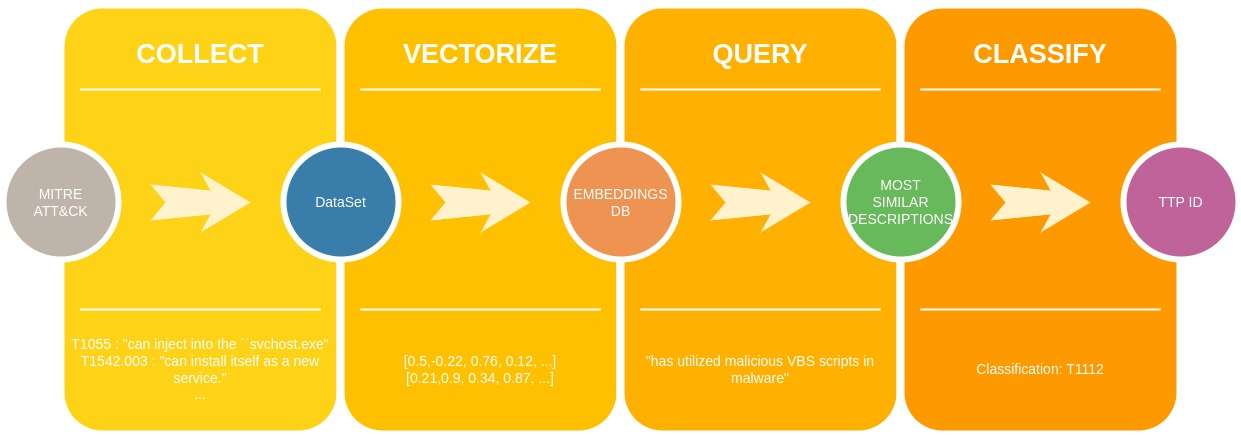

In [268]:
from IPython.display import Image
Image("/home/hamzicd/Documents/TTP-Classification-Concept-Overview.jpg")
#Image("/home/hamzicd/Downloads/1_FG5PuAFbrk63eOAu4mafkw.webp")

In [2]:
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

import pprint
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain.docstore.document import Document

import os

os.environ['OPENAI_API_KEY'] = 'xxx'

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
from mitreattack.stix20 import MitreAttackData

mitre_attack_data = MitreAttackData("./DATA/enterprise-attack-15.1.json")
software = mitre_attack_data.get_software(remove_revoked_deprecated=True)
print(f"Retrieved {len(software)} ATT&CK software.")

Retrieved 678 ATT&CK software.


In [4]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /home/hamzicd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
tp_holder = {}

technique_list = mitre_attack_data.get_techniques()
for t in technique_list:
    ttpid = t["external_references"][0]["external_id"]
    description_list = sent_tokenize(t["description"])

    procedure_desc_list = []
    procedure_list = mitre_attack_data.get_procedure_examples_by_technique(t["id"])
    for p in procedure_list:
        procedure_desc_list.append(p["description"])
        
    tp_holder[ttpid] = procedure_desc_list + description_list#description_list#procedure_desc_list + 
    #break

In [6]:
print(len(set(tp_holder.keys())))

780


In [7]:
# Converting dictionary to DataFrame
rows = []
for key, values in tp_holder.items():
    for value in values:
        rows.append((key, value))

df = pd.DataFrame(rows, columns=['Key', 'Value'])

In [8]:
len(set(df.Key))

780

In [9]:
df['Value'] = df['Value'].str.replace(r'\([^)]*\)', '', regex=True)
df['Value'] = df['Value'].str.replace(r'\[.*?\]', '', regex=True)

# Remove rows with empty string in Value column
df = df[df['Value'].str.strip() != '']
# Remove "\n" from strings in Value column and strip each string
df['Value'] = df['Value'].str.replace('\n', '').str.strip()
df.head()

,Key,Value
0,T1055.011,has overwritten the function pointer in the ex...
1,T1055.011,overwrites Explorer’s Shell_TrayWnd extra wind...
2,T1055.011,Adversaries may inject malicious code into pro...
3,T1055.011,EWM injection is a method of executing arbitra...
4,T1055.011,"Before creating a window, graphical Windows-ba..."


In [10]:
df['Key'] = df['Key'].apply(lambda x: x.split('.')[0])

In [11]:
df["Key"].value_counts().head(100)

Key
T1059    932
T1027    745
T1071    484
T1070    475
T1105    468
        ... 
T1571     48
T1068     47
T1586     46
T1490     45
T1542     44
Name: count, Length: 100, dtype: int64

In [12]:
df.iloc[0].values

array(['T1055',
       "has overwritten the function pointer in the extra window memory of Explorer's Shell_TrayWnd in order to execute malicious code in the context of the explorer.exe process."],
      dtype=object)

In [13]:
len(df["Key"].unique())

342

In [14]:
df

,Key,Value
0,T1055,has overwritten the function pointer in the ex...
1,T1055,overwrites Explorer’s Shell_TrayWnd extra wind...
2,T1055,Adversaries may inject malicious code into pro...
3,T1055,EWM injection is a method of executing arbitra...
4,T1055,"Before creating a window, graphical Windows-ba..."
...,...,...
20099,T1574,System and user-wide environment variable scop...
20100,T1574,A process scope COR_PROFILER can also be creat...
20101,T1574,"Starting with .NET Framework 4, the profiling ..."
20102,T1574,Adversaries may abuse COR_PROFILER to establis...


### Read IN the TRAM Dataset

In [273]:
df2 = pd.read_json("./DATA/single_label.json")
df2.rename(columns={'text': 'Value', 'label': 'Key'}, inplace=True)

In [16]:
train, test = train_test_split(df, test_size=0.0015, random_state=0)
print(len(test))

30


#### Read In other Datasets

In [17]:
#train.to_csv('mitre_TTP_descriptions_TRAM_train.csv', index=False) 
#train = pd.read_csv("mitre_TTP_descriptions_TRAM_augmented.csv")
train

,Key,Value
10896,T1064,"used Visual Basic Scripts , JavaScript code, b..."
16673,T1070,can remove files from the compromised host.
15277,T1065,has been observed communicating over non stand...
16118,T1059,can launch an interface where it can execute s...
6767,T1219,has used a modified TeamViewer client as a com...
...,...,...
13363,T1562,"), which may lead to bypassing anti-tampering ..."
20001,T1078,"can brute force a local admin password, then u..."
10033,T1588,has used malware obtained after compromising o...
11006,T1559,This may also include identifying and abusing ...


### NGRAM

In [298]:
# Function to generate n-grams
def generate_ngrams(text, n):
    words = text.split()
    ngrams = zip(*[words[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

# Function to expand n-grams into separate rows
def expand_ngrams(df, n):
    rows = []
    for _, row in df.iterrows():
        ngrams = generate_ngrams(row['Value'], n)
        for ngram in ngrams:
            rows.append({'Value': ngram, 'Key': row['Key']})
    return pd.DataFrame(rows)

# Expand bigrams
bigrams_df = expand_ngrams(train, 3)
print("Bigrams DataFrame")
#print(bigrams_df)
bigrams_df
## Expand trigrams (optional)
#trigrams_df = expand_ngrams(df, 3)
#print("Trigrams DataFrame")
#print(trigrams_df)

Bigrams DataFrame


,Value,Key
0,The actors’ exploit,T1053.005
1,actors’ exploit payload,T1053.005
2,exploit payload created,T1053.005
3,payload created Scheduled,T1053.005
4,created Scheduled Task,T1053.005
...,...,...
33883,The activity thereafter,T1003.001
33884,activity thereafter included,T1003.001
33885,thereafter included dumps,T1003.001
33886,included dumps of,T1003.001


In [281]:
#train = bigrams_df

In [18]:
### embedding
model = "sentence-transformers/multi-qa-MiniLM-L6-cos-v1"
embeddings = HuggingFaceEmbeddings(model_name = model)

#embeddings=OpenAIEmbeddings()

docs = []
for index, row in train.iterrows():
    doc = Document(page_content=row["Value"], metadata={"TTP_ID": row["Key"]})
    docs.append(doc)

print(len(docs))

/home/hamzicd/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/hamzicd/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/hamzicd/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


19717


In [19]:
db = FAISS.from_documents(docs, embeddings)

In [256]:
db.save_local("faiss_index_MITRE_train_augmented")

In [80]:
new_db = FAISS.load_local("faiss_index_augmented_ds", embeddings, allow_dangerous_deserialization=True)

In [23]:
query = "disguised its scheduled tasks as those used by Google"
docs = db.similarity_search_with_score(query, k=30)
#docs = db.max_marginal_relevance_search(text_to_predict,k=17, fetch_k=30)
print('Retrieved docs:', docs)
print('Metadata of the most relevant document:', docs[0][0].metadata)

Retrieved docs: [(Document(page_content='has disguised its scheduled tasks as those used by Google.', metadata={'TTP_ID': 'T1036'}), 0.25545275), (Document(page_content='has used a macro function to set scheduled tasks, disguised as those used by Google.', metadata={'TTP_ID': 'T1053'}), 0.3665668), (Document(page_content='has created scheduled tasks using name variants such as "Windows Update Security", "Windows Update Security Patches", and "Google Chrome Security Update", to launch  at a specific time.', metadata={'TTP_ID': 'T1053'}), 0.6577332), (Document(page_content='Adversaries may also create "hidden" scheduled tasks (i.e.', metadata={'TTP_ID': 'T1053'}), 0.6946305), (Document(page_content='is able to create “hidden” scheduled tasks for persistence.', metadata={'TTP_ID': 'T1053'}), 0.75075793), (Document(page_content='is able to create “hidden” scheduled tasks by deleting the Security Descriptor  registry value.', metadata={'TTP_ID': 'T1564'}), 0.7582741), (Document(page_content

In [24]:
len(test)

30

In [40]:
#for doc, score in docs:
#    print(doc.page_content)

In [41]:
#for doc in docs:
#    print(doc.page_content)

### Question-Answer Ranking

In [25]:
import torch
from sentence_transformers import CrossEncoder
model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512, 
                     default_activation_function=torch.nn.Sigmoid())

In [59]:
#answers = [doc.page_content for doc, score in docs]
#answers

In [65]:
#scores = model.predict([(query, answers[0]), (query, answers[1]), (query, answers[2])])
scores = model.predict([(query, doc.page_content) for doc, score in docs])
print(scores)

#docs[,scores > 0.70]

[0.99988604 0.99969363 0.8925538  0.32304642 0.37149552 0.7660167
 0.7902567  0.2873494  0.03794144 0.23826294 0.08709966 0.026929
 0.10621969 0.07961532 0.02990808 0.17285344 0.03719693 0.12051528
 0.12051528 0.02757921 0.49186125 0.15068778 0.0313541  0.1361097
 0.03436381 0.05681773 0.02713206 0.07345916 0.9103448  0.03882612]


In [58]:
len(scores > 0.70)

30

In [80]:
#text_to_predict
#search_results

filtered_search_results = []
for doc, score in search_results:
    mscore = model.predict([text_to_predict, doc.page_content.lower().strip()])
    if mscore > 0.80:
        filtered_search_results.append((doc,score))

### Voting

In [285]:
predicted_labels = []
# Iterating over the DataFrame row by row
for index, row in test.iterrows():
    #print(f"Index: {index}")
    text_to_predict = row["Value"]
    
    #search_results = db.similarity_search_with_score(text_to_predict, k=7)#[0][0].metadata["TTP_ID"]
    search_results = db.similarity_search_with_score(text_to_predict, k=13)#[0][0].metadata["TTP_ID"]
    ttp_ids = [doc.metadata['TTP_ID'] for doc, _ in search_results]
    # get majority
    ttp_id_counts = Counter(ttp_ids)
    most_common_ttp_id, count = ttp_id_counts.most_common(1)[0]
    predicted_label = most_common_ttp_id
    
    predicted_labels.append(predicted_label)
    #print("actual:", row["Key"], ", predicted:", predicted_label)
    #print("\n")
    #break

### Few-shot learning

In [81]:
from langchain_openai import ChatOpenAI

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o", temperature=1)### , model_kwargs={"top_p": 0.5}
#llm.invoke(prompt)


predicted_labels = []
# Iterating over the DataFrame row by row
for index, row in test.iterrows():
    #print(f"Index: {index}")
    text_to_predict = row["Value"]

    ##### Prompt 1
    search_results = db.similarity_search_with_score(text_to_predict, k=45)

    '''
    filtered_search_results = []
    for doc, score in search_results:
        mscore = model.predict([text_to_predict, doc.page_content.lower().strip()])
        if mscore > 0.80:
            filtered_search_results.append((doc,score))
    '''
    
    xs = ["\nText:"+ doc.page_content.lower().strip()+"\nSimilarity:"+ str(score) +"\nClassification:"+doc.metadata['TTP_ID']+"\n" for doc, score in filtered_search_results]

    xs = ''.join(xs)+"\nInputText:"+ text_to_predict.lower().strip() +"\nClassification:"
    xs = "Your task is to classify the last sentence of 'InputText' based on the provided examples. Each example shows a sentence, inverse similarity to InputText (the lower the better), and its corresponding classification label. Use these examples to determine the correct classification for the given text. Return only the classification label starting with 'T'.\n" + xs
    #####
    
    ### search
    '''
    search_results = db.similarity_search_with_score(text_to_predict, k=55)
    xs = ["\n"+ "Example "+ str(i) +":\nText:"+ doc.page_content.lower()+"\nClassification:"+doc.metadata['TTP_ID']+"\n" for i, (doc, _) in enumerate(search_results)]
    ##xs = ["\nText:"+" ".join(str(doc.page_content).lower().split())+"\nClassification:"+doc.metadata['TTP_ID'] for doc, _ in search_results]
    

    ### mmr search
    #search_results = db.max_marginal_relevance_search(text_to_predict,k=45, fetch_k=250)
    #xs = ["\nText:"+doc.page_content.lower()+"\nClassification:"+doc.metadata['TTP_ID'] for doc in search_results]

    
    xs += "\n\nNote: The examples show a pattern where certain attack behaviors correspond to specific classification labels. Use this pattern recognition to classify the new text accurately.\nNow, classify the following text:\n"
    xs = ''.join(xs)+"\nText:"+ text_to_predict.lower() +"\nClassification:"
    #xs = "Your task is to classify the last sentence of 'Text' based on the provided examples. Each example shows a sentence and its corresponding classification label. Use these examples to determine the correct classification for the given text. Return only the classification label starting with 'T'.\n" + xs
    xs = "Your task is to classify the last sentence of 'Text' based on the diverse examples provided below. Learn the patterns from these examples to make accurate classifications. Output only the classification label beginning with 'T'.\n\nExamples:\n" + xs
    '''
    #print(xs)
    prompt = xs#prompt#"Write a poem about a cat chasing a butterfly."
    result = llm.invoke(prompt)
    predicted_label = result.content
    
    #predicted_label = most_common_ttp_id
    #print(predicted_label)
    predicted_labels.append(predicted_label)
    print("actual:", row["Key"], ", predicted:", predicted_label)
    #break

actual: T1094 , predicted: T1027
actual: T1012 , predicted: T900
actual: T1499 , predicted: T1499
actual: T1585 , predicted: T1585
actual: T1552 , predicted: T1003
actual: T1566 , predicted: T1566
actual: T1071 , predicted: T1071
actual: T1175 , predicted: T1021
actual: T1586 , predicted: T1078
actual: T1053 , predicted: T1036
actual: T1065 , predicted: T1065
actual: T1110 , predicted: T1110
actual: T1186 , predicted: T1055
actual: T1562 , predicted: T1562
actual: T1070 , predicted: T1574
actual: T1553 , predicted: T1553
actual: T1593 , predicted: T1598
actual: T1078 , predicted: T1078
actual: T1573 , predicted: T1573
actual: T1546 , predicted: T1519
actual: T1090 , predicted: T1090
actual: T1588 , predicted: T1588
actual: T1064 , predicted: T1059
actual: T1074 , predicted: T1074
actual: T1595 , predicted: T1033
actual: T1071 , predicted: T1071
actual: T1547 , predicted: T1547
actual: T1083 , predicted: T1518
actual: T1007 , predicted: T1007
actual: T1018 , predicted: T1570


In [82]:
print(xs)

Your task is to classify the last sentence of 'InputText' based on the provided examples. Each example shows a sentence, inverse similarity to InputText (the lower the better), and its corresponding classification label. Use these examples to determine the correct classification for the given text. Return only the classification label starting with 'T'.

Text:attempts to copy itself to remote machines on the network.
Similarity:0.65632254
Classification:T1570

Text:attempts to copy itself to remote machines on the network.
Similarity:0.65632254
Classification:T1570

Text:attempts to copy itself to remote computers after gaining access via an smb exploit.
Similarity:0.79542756
Classification:T1570

InputText:scans its local network segment for remote systems to try to exploit and copy itself to.
Classification:


### Few Shot learning 2

In [290]:
# Aggregate predictions using majority voting
from collections import Counter

def majority_voting(predictions):
    count = Counter(predictions)
    return count.most_common(1)[0][0]

In [291]:
import random

def create_prompt(template, search_results, text_to_predict):
    xs = ["\nText:"+ doc.page_content.lower()+"\nClassification:"+doc.metadata['TTP_ID'] for doc, _ in search_results]
    xs = ''.join(xs)+"\nText:"+ text_to_predict.lower() +"\nClassification:"
    return template + xs

def split_list(lst):
    random.shuffle(lst)  # Shuffle the list to ensure randomness
    n = len(lst)
    third = n // 3
    remainder = n % 3

    # Determine the splitting points
    split1 = third
    split2 = third * 2

    if remainder == 1:
        split1 += 1
    elif remainder == 2:
        split1 += 1
        split2 += 1

    # Split the list
    first_third = lst[:split1]
    second_third = lst[split1:split2]
    third_third = lst[split2:]

    return first_third, second_third, third_third



predicted_labels = []
# Iterating over the DataFrame row by row
for index, row in test.iterrows():
    #print(f"Index: {index}")
    text_to_predict = row["Value"]

    search_results = db.similarity_search_with_score(text_to_predict, k=150)

    template1 = "Your task is to classify the last sentence of 'Text' based on the provided examples. Each example shows a sentence and its corresponding classification label. Use these examples to determine the correct classification for the given text. Return only the classification label starting with 'T'.\n"
    template2 = "Please classify the last sentence of 'Text' based on the provided examples. Each example shows a sentence and its classification label. Use the patterns from these examples to classify the given text correctly. Return only the classification label starting with 'T'.\n"
    template3 = "Your task is to determine the classification of the last sentence of 'Text' using the provided examples. Each example pairs a sentence with its classification label. Analyze these examples to classify the given text. Output only the classification label starting with 'T'.\n"

    ## Split the list
    first_part, second_part, third_part = split_list(search_results)

    
    prompt1 = create_prompt(template1, first_part, text_to_predict)
    prompt2 = create_prompt(template2, second_part, text_to_predict)
    prompt3 = create_prompt(template3, third_part, text_to_predict)
    
    # Collect predictions
    prompts = [prompt1, prompt2, prompt3]
    predictions = []
    
    for prompt in prompts:
        
        prediction = llm.invoke(prompt).content
        predictions.append(prediction)

    print(predictions)
    
    
    final_prediction = majority_voting(predictions)
    #print("Final Prediction:", final_prediction)
    predicted_labels.append(final_prediction)
    print("actual:", row["Key"], ", predicted:", final_prediction)
    

['T1055', 'T1041', 'T1082']
actual: T1041 , predicted: T1055
['T1027', 'T1140', 'T1140']
actual: T1140 , predicted: T1140
['T1027', 'T1027', 'T1027']
actual: T1112 , predicted: T1027
['T1548.002', 'T1548.002', 'T1548.002']
actual: T1548.002 , predicted: T1548.002
['T1573.001', 'T1573.001', 'T1573.001']
actual: T1573.001 , predicted: T1573.001
['T1140', 'T1140', 'T1140']
actual: T1140 , predicted: T1140
['T1543.003', 'T1543.003', 'T1112']
actual: T1543.003 , predicted: T1543.003
['T1027', 'T1027', 'T1027']
actual: T1027 , predicted: T1027
['T1036.005', 'T1036.005', 'T1036.005']
actual: T1036.005 , predicted: T1036.005
['T1027', 'T1547.001', 'T1112']
actual: T1027 , predicted: T1027
['T1204.002', 'T1566.001', 'T1566.001']
actual: T1204.002 , predicted: T1566.001
['T1003.001', 'T1003.001', 'T1003.001']
actual: T1003.001 , predicted: T1003.001
['T1070.004', 'T1070.004', 'T1027']
actual: T1070.004 , predicted: T1070.004
['T1059.003', 'T1059.003', 'T1059.003']
actual: T1059.003 , predicted: 

In [270]:
print(xs)

Your task is to classify the last sentence of 'InputText' based on the provided examples. Each example shows a sentence, inverse similarity to InputText (the lower the better), and its corresponding classification label. Use these examples to determine the correct classification for the given text. Return only the classification label starting with 'T'.

Text:readregistryvalue
Similarity:0.5447331
Classification:T1012

Text:readregistryvalue
Similarity:0.5447331
Classification:T1012

Text:readregistryvalue
Similarity:0.5447331
Classification:T1012

Text:sets various registry values
Similarity:0.87404203
Classification:T1112

Text:getregistrysubkeyandvaluenames
Similarity:0.9959117
Classification:T1012

Text:getregistrysubkeyandvaluenames
Similarity:0.9959117
Classification:T1012

Text:getregistrysubkeyandvaluenames
Similarity:0.9959117
Classification:T1012

Text:it then sets registry entries
Similarity:1.0865843
Classification:T1112

Text:registry key sets
Similarity:1.1134652
Classifi

In [ ]:
["registry", "key", "sets"]

In [203]:
import numpy as np
from collections import Counter

def create_prompt(template, search_results, text_to_predict):
    examples = ["\nText: " + doc.page_content.lower() + "\nClassification: " + doc.metadata['TTP_ID'] for doc, _ in search_results]
    prompt = ''.join(examples) + "\nText: " + text_to_predict.lower() + "\nClassification:"
    return template + prompt

def split_list(lst):
    n = len(lst)
    third = n // 3
    remainder = n % 3

    split1 = third + (1 if remainder > 0 else 0)
    split2 = split1 + third + (1 if remainder > 1 else 0)

    return lst[:split1], lst[split1:split2], lst[split2:]

def weighted_voting(predictions, weights):
    weighted_counts = Counter()
    for prediction, weight in zip(predictions, weights):
        weighted_counts[prediction] += weight
    return weighted_counts.most_common(1)[0][0]

def normalize_text(text):
    return text.lower().strip()

# Define your templates
templates = [
    "Your task is to classify the last sentence of 'Text' based on the provided examples. Each example shows a sentence and its corresponding classification label. Use these examples to determine the correct classification for the given text. Return only the classification label starting with 'T'.\n",
    "Please classify the last sentence of 'Text' based on the provided examples. Each example shows a sentence and its classification label. Use the patterns from these examples to classify the given text correctly. Return only the classification label starting with 'T'.\n",
    "Your task is to determine the classification of the last sentence of 'Text' using the provided examples. Each example pairs a sentence with its classification label. Analyze these examples to classify the given text. Output only the classification label starting with 'T'.\n"
]

weights = [1.0, 1.0, 1.0]  # Initially equal weights

predicted_labels = []
for index, row in test.iterrows():
    text_to_predict = normalize_text(row["Value"])
    search_results = db.similarity_search_with_score(text_to_predict, k=300)

    first_part, second_part, third_part = split_list(search_results)

    parts = [first_part, second_part, third_part]
    prompts = [create_prompt(template, part, text_to_predict) for template, part in zip(templates, parts)]
    
    predictions = []
    for prompt in prompts:
        prediction = llm.invoke(prompt).content.strip()  # Strip any extra whitespace
        predictions.append(prediction)

    print("Predictions:", predictions)
    
    final_prediction = weighted_voting(predictions, weights)
    predicted_labels.append(final_prediction)
    print("Actual:", row["Key"], ", Predicted:", final_prediction)

# At this point, you might also consider tuning the weights based on performance on a validation set.


Predictions: ['T1082', 'T1041', 'T1078']
Actual: T1041 , Predicted: T1082
Predictions: ['T1140', 'T1140', 'T1140']
Actual: T1140 , Predicted: T1140
Predictions: ['T1027', 'T1112', 'T1027']
Actual: T1112 , Predicted: T1027
Predictions: ['T1548.002', 'T1548.002', 'T1548.002']
Actual: T1548.002 , Predicted: T1548.002
Predictions: ['T1140', 'T1573.001', 'T1140']
Actual: T1573.001 , Predicted: T1140
Predictions: ['T1140', 'T1140', 'T1140']
Actual: T1140 , Predicted: T1140
Predictions: ['T1543.003', 'T1543.003', 'T1036.005']
Actual: T1543.003 , Predicted: T1543.003
Predictions: ['T1027', 'T1027', 'T1027']
Actual: T1027 , Predicted: T1027
Predictions: ['T1036.005', 'T1036.005', 'T1036.005']
Actual: T1036.005 , Predicted: T1036.005
Predictions: ['T1027', 'T1112', 'T1027']
Actual: T1027 , Predicted: T1027
Predictions: ['T1204.002', 'T1566.001', 'T1204.001']
Actual: T1204.002 , Predicted: T1204.002
Predictions: ['T1003.001', 'T1003.001', 'T1003.001']
Actual: T1003.001 , Predicted: T1003.001
Pred

In [216]:
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split

def create_prompt(template, search_results, text_to_predict):
    examples = ["\nText: " + doc.page_content.lower() + "\nClassification: " + doc.metadata['TTP_ID'] for doc, _ in search_results]
    prompt = ''.join(examples) + "\nText: " + text_to_predict.lower() + "\nClassification:"
    return template + prompt

def split_list(lst):
    n = len(lst)
    third = n // 3
    remainder = n % 3

    split1 = third + (1 if remainder > 0 else 0)
    split2 = split1 + third + (1 if remainder > 1 else 0)

    return lst[:split1], lst[split1:split2], lst[split2:]

def weighted_voting(predictions, weights):
    weighted_counts = Counter()
    for prediction, weight in zip(predictions, weights):
        weighted_counts[prediction] += weight
    return weighted_counts.most_common(1)[0][0]

def normalize_text(text):
    return text.lower().strip()

def evaluate_weights(weights, validation_data):
    correct_predictions = 0
    total_predictions = len(validation_data)
    
    for index, row in validation_data.iterrows():
        text_to_predict = normalize_text(row["Value"])
        search_results = db.similarity_search_with_score(text_to_predict, k=300)

        first_part, second_part, third_part = split_list(search_results)

        parts = [first_part, second_part, third_part]
        prompts = [create_prompt(template, part, text_to_predict) for template, part in zip(templates, parts)]

        predictions = []
        for prompt in prompts:
            prediction = llm.invoke(prompt).content.strip()  # Strip any extra whitespace
            predictions.append(prediction)

        final_prediction = weighted_voting(predictions, weights)
        
        if final_prediction == row["Key"]:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy

# Split the dataset into training and validation sets
train_data, validation_data = train_test_split(test, test_size=0.2, random_state=42)

# Define your templates
templates = [
    "Your task is to classify the last sentence of 'Text' based on the provided examples. Each example shows a sentence and its corresponding classification label. Use these examples to determine the correct classification for the given text. Return only the classification label starting with 'T'.\n",
    "Please classify the last sentence of 'Text' based on the provided examples. Each example shows a sentence and its classification label. Use the patterns from these examples to classify the given text correctly. Return only the classification label starting with 'T'.\n",
    "Your task is to determine the classification of the last sentence of 'Text' using the provided examples. Each example pairs a sentence with its classification label. Analyze these examples to classify the given text. Output only the classification label starting with 'T'.\n"
]

# Define the weight combinations to try
weight_combinations = [
    [1.0, 1.0, 1.0],
    [1.0, 0.5, 0.5],
    [0.5, 1.0, 0.5],
    [0.5, 0.5, 1.0],
    [1.5, 1.0, 0.5],
    [0.5, 1.5, 1.0],
    [1.0, 0.5, 1.5],
    # Add more combinations if needed
]

# Grid search for the best weights
best_weights = None
best_accuracy = 0

for weights in weight_combinations:
    accuracy = evaluate_weights(weights, validation_data)
    print(f"Weights: {weights}, Accuracy: {accuracy:.4f}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights = weights

print(f"Best Weights: {best_weights}, Best Accuracy: {best_accuracy:.4f}")

# Use the best weights for prediction
predicted_labels = []
for index, row in train_data.iterrows():
    text_to_predict = normalize_text(row["Value"])
    search_results = db.similarity_search_with_score(text_to_predict, k=300)

    first_part, second_part, third_part = split_list(search_results)

    parts = [first_part, second_part, third_part]
    prompts = [create_prompt(template, part, text_to_predict) for template, part in zip(templates, parts)]

    predictions = []
    for prompt in prompts:
        prediction = llm.invoke(prompt).content.strip()  # Strip any extra whitespace
        predictions.append(prediction)

    final_prediction = weighted_voting(predictions, best_weights)
    predicted_labels.append(final_prediction)
    print("Actual:", row["Key"], ", Predicted:", final_prediction)


Weights: [1.0, 1.0, 1.0], Accuracy: 0.6875
Weights: [1.0, 0.5, 0.5], Accuracy: 0.8125
Weights: [0.5, 1.0, 0.5], Accuracy: 0.6875
Weights: [0.5, 0.5, 1.0], Accuracy: 0.7500
Weights: [1.5, 1.0, 0.5], Accuracy: 0.8125


KeyboardInterrupt: 

In [ ]:
#print(prompt3)
#earch_results[0:5]

In [ ]:
#test.Key.values

### Evaluate

In [83]:

cleaned_labels = [label.replace('Classification:', '') for label in predicted_labels]

# Example vectors containing strings
y_true = test.Key.values#["cat", "dog", "fish", "cat", "dog"]
#y_true = train_data.Key
y_pred = cleaned_labels#.values#["cat", "dog", "cat", "cat", "dog"]

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall}")

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1}")

Accuracy: 0.5333333333333333


/home/hamzicd/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.5166666666666667


/home/hamzicd/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recall: 0.5333333333333333
F1 Score: 0.5222222222222223



* (NGRAM) TRAM 50 TTPs dataset ## Few-Shot (lowercase, strip, temperature=1) k=45 (simple prompt format)
Accuracy: 0.7272727272727273
Precision: 0.8346861471861471
Recall: 0.7272727272727273
F1 Score: 0.7517666018113845



* TRAM 50 TTPs dataset ## Few-Shot (lowercase, strip, temperature=1) k=45 (simple prompt format)
Accuracy: 0.948051948051948
Precision: 0.987012987012987
Recall: 0.948051948051948
F1 Score: 0.9645530939648587


* TRAM 50 TTPs dataset ## Few-Shot (lowercase) k=45 (simple prompt format)
Accuracy: 0.948051948051948
Precision: 0.9749536178107606
Recall: 0.948051948051948
F1 Score: 0.9573833573833574


# "Your task is to classify the last sentence of 'Text' based on the diverse examples provided below. Learn the patterns from these examples to make accurate classifications. Output only the classification label beginning with 'T'.\n" + xs
Accuracy: 0.935064935064935
Precision: 0.9619666048237476
Recall: 0.935064935064935
F1 Score: 0.9443963443963445


* TRAM 50 TTPs dataset ## Few-Shot (lowercase) k=45 (simple prompt format)
Accuracy: 0.935064935064935
Precision: 0.9749536178107606
Recall: 0.935064935064935
F1 Score: 0.9505078799196447


* TRAM 50 TTPs dataset ## Few-Shot (split, lowercase) k=45
Accuracy: 0.922077922077922
Precision: 0.961038961038961
Recall: 0.922077922077922
F1 Score: 0.9394448688566336


* TRAM 50 TTPs dataset ## Few-Shot -> db.max_marginal_relevance_search(text_to_predict,k=7, fetch_k=50)
Accuracy: 0.8961038961038961
Precision: 0.948051948051948
Recall: 0.8961038961038961
F1 Score: 0.9143939393939393


* TRAM 50 TTPs dataset ## Few-Shot -> db.similarity_search_with_score(text_to_predict, k=30)
Accuracy: 0.9090909090909091
Precision: 0.9499072356215212
Recall: 0.9090909090909091
F1 Score: 0.9259379509379508


* TRAM 50 TTPs dataset ## Few-Shot -> db.similarity_search_with_score(text_to_predict, k=60)
Accuracy: 0.9090909090909091
Precision: 0.9239177489177489
Recall: 0.9090909090909091
F1 Score: 0.9119029429953799


* TRAM 50 TTPs dataset ## Few-Shot -> db.similarity_search_with_score(text_to_predict, k=90)
Accuracy: 0.9090909090909091
Precision: 0.9428571428571428
Recall: 0.9090909090909091
F1 Score: 0.9144557823129251


* TRAM 50 TTPs dataset ## Few-Shot -> db.similarity_search_with_score(text_to_predict, k=45)
Accuracy: 0.922077922077922
Precision: 0.9533085961657389
Recall: 0.922077922077922
F1 Score: 0.9323260617378264


* TRAM 50 TTPs dataset ## Few-Shot -> db.similarity_search_with_score(text_to_predict, k=15)
Accuracy: 0.8831168831168831
Precision: 0.9223098330241187
Recall: 0.8831168831168831
F1 Score: 0.89901900154001


* Few shot db.similarity_search_with_score(text_to_predict, k=30)
Accuracy: 0.7306397306397306
Precision: 0.7616795662250208
Recall: 0.7306397306397306
F1 Score: 0.7271133999204175

* Voting * k=7
Accuracy: 0.611336032388664
Precision: 0.6072593342330184
Recall: 0.611336032388664
F1 Score: 0.5834830127974958

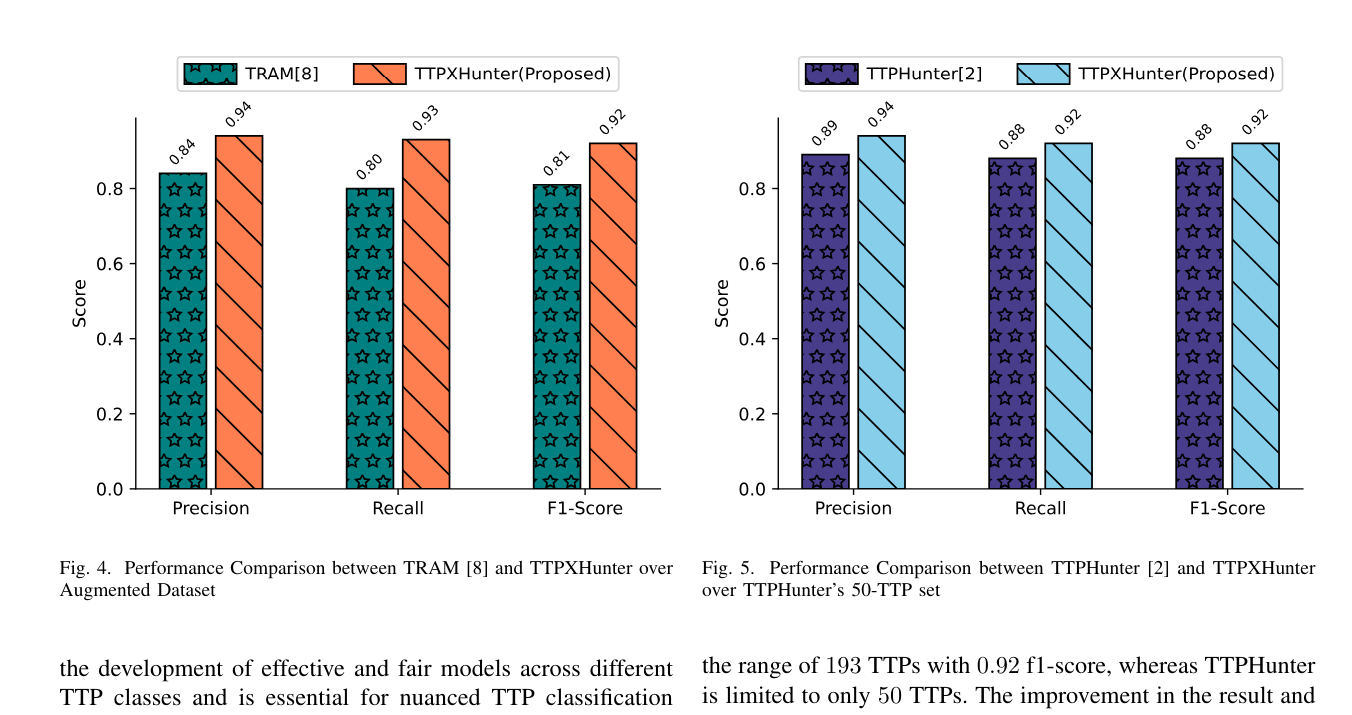

In [33]:
from IPython.display import Image
Image("/home/hamzicd/Pictures/Screenshots/Screenshot from 2024-06-08 23-02-16.png")

In [271]:
### TODO
NGRAM vergleich

SyntaxError: invalid syntax (1580923819.py, line 2)

In [272]:
from sklearn.feature_extraction.text import CountVectorizer

text_data = [
    "Attacker has used multiple proxies to obfuscate network traffic from victims.",
    "Attacker have added explanation to specific grouping with <codification> net localgroup </ code >.",
    "Attacker has created bogus LinkedIn and early social media chronicle to meet targets and convince them - - done messages and voice communicating - - to open malicious inter group communication."
]

# Create a CountVectorizer for bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2))
X = vectorizer.fit_transform(text_data)

print(vectorizer.get_feature_names_out())
print(X.toarray())

['added explanation' 'and convince' 'and early' 'and voice' 'attacker has'
 'attacker have' 'bogus linkedin' 'chronicle to' 'codification net'
 'communicating to' 'convince them' 'created bogus' 'done messages'
 'early social' 'explanation to' 'from victims' 'group communication'
 'grouping with' 'has created' 'has used' 'have added' 'inter group'
 'linkedin and' 'localgroup code' 'malicious inter' 'media chronicle'
 'meet targets' 'messages and' 'multiple proxies' 'net localgroup'
 'network traffic' 'obfuscate network' 'open malicious' 'proxies to'
 'social media' 'specific grouping' 'targets and' 'them done' 'to meet'
 'to obfuscate' 'to open' 'to specific' 'traffic from' 'used multiple'
 'voice communicating' 'with codification']
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0
  0 0 0 1 0 0 1 1 0 0]
 [1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1
  0 0 0 0 0 1 0 0 0 1]
 [0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 1 0 0 0